## Load data container

In [ ]:
import os, uuid
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

account_url = "https://dasdata.blob.core.windows.net"

blob_service_client = BlobServiceClient(account_url)

In [2]:
container_client = blob_service_client.get_container_client("zarr")

container_client.get_container_properties()

{'name': 'zarr', 'last_modified': datetime.datetime(2023, 2, 2, 14, 24, 54, tzinfo=datetime.timezone.utc), 'etag': '"0x8DB052940E27EBB"', 'lease': {'status': 'unlocked', 'state': 'available', 'duration': None}, 'public_access': 'container', 'has_immutability_policy': False, 'deleted': None, 'version': None, 'has_legal_hold': False, 'metadata': {}, 'encryption_scope': <azure.storage.blob._models.ContainerEncryptionScope object at 0x7f4a9a7cddb0>, 'immutable_storage_with_versioning_enabled': False}

In [4]:
# !pip install xarray[complete] --upgrade

In [5]:
# !pip install fsspec --upgrade

In [6]:
# !pip install adlfs --upgrade

In [7]:
import azure.storage.blob
import zarr
store = zarr.ABSStore(client=container_client, prefix='ooi_South_Tx.zarr/ooi_South_Tx.zarr')
root = zarr.group(store=store)  


In [8]:
import xarray as xr

ds = xr.open_zarr(store)

In [9]:
ds

<xarray.Dataset>
Dimensions:      (time: 39168000, distance: 47500)
Dimensions without coordinates: time, distance
Data variables:
    GpBits       (time) uint8 dask.array<chunksize=(3000,), meta=np.ndarray>
    GpsStatus    (time) uint8 dask.array<chunksize=(3000,), meta=np.ndarray>
    PpsOffset    (time) uint32 dask.array<chunksize=(3000,), meta=np.ndarray>
    RawData      (distance, time) int32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    RawDataTime  (time) int64 dask.array<chunksize=(3000,), meta=np.ndarray>
    SampleCount  (time) int64 dask.array<chunksize=(3000,), meta=np.ndarray>

## Methods for signal processing

In [10]:
import h5py
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from datetime import datetime
from pyproj import Proj
import requests
import bs4
import os
import sys
from PIL import Image

In [11]:
def median_subtract(rawData):
    """
    Subtract median of each timepoint from all traces
    """
    return rawData - np.tile(np.median(rawData,axis=1),(rawData.shape[1],1)).T

def bandpass_filter(rawData, low, high):
    """
    Apply a bandpass filter to the data.
    """

    fs = 200
    
    assert fs > 2*high, "High frequency must be less than half the sampling frequency."

    nyq = fs/2
    low = low/nyq
    high = high/nyq
    
    b, a = sp.butter(4, [low, high], 'bandpass')
    
    return sp.filtfilt(b, a, rawData, axis=1)

def calc_envelope(rawData):
    """
    Calculate the envelope of the data and return its log transform.
    """
    return np.log(np.abs(sp.hilbert(rawData, axis=1)+1))

In [12]:
data_slice = ds.RawData.isel({'time':slice(0, 200*60*1, 2), 'distance':slice(20000, 25000, 5)})

In [13]:
data_slice

<xarray.DataArray 'RawData' (distance: 1000, time: 6000)>
dask.array<getitem, shape=(1000, 6000), dtype=int32, chunksize=(600, 1500), chunktype=numpy.ndarray>
Dimensions without coordinates: distance, time

## Example operation for one data slice

In [14]:
df = data_slice.to_numpy()

In [15]:
df.shape

(1000, 6000)

In [16]:
def save_to_image(filename, data):
    """
    Save the data to an image file.
    """
    data = (data - np.min(data))/(np.max(data) - np.min(data))*255 #Normalize
    
    im = Image.fromarray(np.uint8(data.T))
    im.resize((im.width//16, im.height//16)).save('./images/' + filename + '.png')
    im.close()

In [17]:
low = 14
high = 35
file_name = 'tmp'

rawData = median_subtract(df) #Median subtraction
rawData = bandpass_filter(rawData, low, high) #Bandpass filter

envelope = calc_envelope(rawData) #Calculate envelope

#Save to image
save_to_image(file_name, envelope)


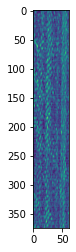

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('./images/tmp.png')
imgplot = plt.imshow(img)
plt.show()

In [19]:
envelope.shape

(1000, 6000)

## Prepare dataset for batch images

In [20]:
from tqdm import tqdm

In [28]:
time_interval_seconds = 120
distance_min = 10000
distance_max = 40000
start_time_idx = 800
num_images = 100

def save_to_image(filename, data):
    """
    Save the data to an image file.
    """
    data = (data - np.min(data))/(np.max(data) - np.min(data))*255 #Normalize
    
    im = Image.fromarray(np.uint8(data.T))
    im.resize((im.width//16, im.height//16)).save('./images/' + str(int(distance_min/100)) + '-'  + str(int(distance_max/100)) + 'km-' + str(time_interval_seconds) + 's/' + filename + '.png')
    im.close()


from pathlib import Path
Path('./images/' + str(int(distance_min/100)) + '-'  + str(int(distance_max/100)) + 'km-' + str(time_interval_seconds) + 's/').mkdir(parents=True, exist_ok=True)

for i in tqdm(range(start_time_idx, start_time_idx + num_images)):
    data_slice = ds.RawData.isel({'time':slice(200*time_interval_seconds*i, 200*time_interval_seconds*(i+1), 2), 'distance':slice(distance_min, distance_max, 5)})
    df = data_slice.to_numpy()
    low = 14
    high = 35
    file_name = str(i)

    rawData = median_subtract(df) #Median subtraction
    rawData = bandpass_filter(rawData, low, high) #Bandpass filter

    envelope = calc_envelope(rawData) #Calculate envelope

    #Save to image
    save_to_image(file_name, envelope)


100%|██████████| 100/100 [57:14<00:00, 34.34s/it]


In [29]:
# Create zip archive for easy download
import shutil
shutil.make_archive('image-archive', 'zip', './images/')

'/home/wanggy/notebooks/image-archive.zip'